# Определение возраста покупателей

Цель - обучить модель, которая сможет оценивать возраст посетителей супермаркета по внешности, чтобы предлагать потенциально интересные товары и контролировать соблюдение кассирами запрета на продажу алкоголя несовершеннолетним.

Для решения задачи компьютерного зрения нам лучше всего подойдут нейросети: изображения содержат слишком большое количество признаков, чтобы пытаться работать с ними при помощи классических алгоритмов.

## Исследовательский анализ данных

In [5]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


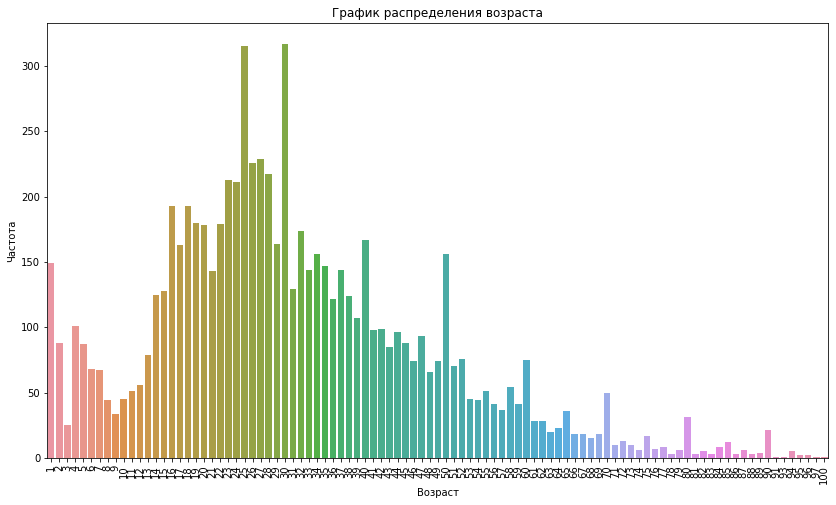

In [6]:
plt.rc('figure', figsize=(14, 8))
sns.countplot(x='real_age', data = labels)
plt.xticks(rotation=90)
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота');

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


- Распределение выборки немного отклонена влево, средний возраст участников -- 31 год. 
- Выборка полная: в ней присутствуют люди всех возрастов, без пропусков
- Выборка неоднородна, т. е. количество людей младшего (меньше 14) и пожилого (больше 50) меньше, чем людей среднего возраста (их большинство) и подростков 14-20 лет. Это может повлиять на качество нашей обученной модели, поскольку она может обучиться лучше угадывать именно людей средней возрастной категории. С другой стороны, нам это и нужно, ведь визуально отличить пожилого человека от человека, например, 35 лет проще, чем 25-летнего от 30-летнего. Тоже самое касается детей. 

In [9]:
# посмотрим на фото участников, загрузим тестовую выборку
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw'
)

Found 7591 validated image filenames.


In [10]:
features, target = next(train_gen_flow)

print(features.shape)

(32, 150, 150, 3)


Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 150x150 с тремя цветовыми каналами.

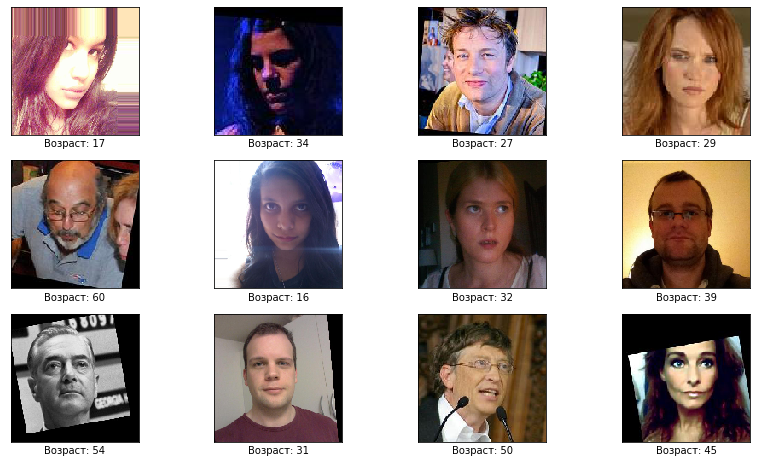

In [11]:
# напечатаем их 
fig=plt.figure(figsize=(14, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
plt.show()

Хочется отметить разнообразность датасета: здесь присутствуют фото не только разновозрастных людей, но и разной национальности. Есть снимки и с разными наклонами головы. Это большой плюс для нашей модели: она будет обучаться на разнообразных снимках, в том числе на фото улыбающихся и кривляющихся людей. 

## Обучение модели

Мы не будем обучать модель здесь, а просто скопируем код, который задаёт её параметры. Сама модель будет обучена на GPU отдельно.

- В качестве модели используем архитектуру ResNet50
- Последним слоем нейронной сети будет полносвязный слой с одним нейроном
- Чтобы получить хорошее качество на валидации, количество эпох оставим равным 10
- В качестве функции потерь зададим MSE.
- Используем в качестве оптимизатора алгоритм Adam с шагом 0.0001

```python

datagen_kws = {'validation_split': .25,
               'rescale': 1./255}

flow_kws = {'x_col': 'file_name',
            'y_col': 'real_age',
            'target_size': (150, 150),
            'batch_size': 16,
            'class_mode': 'raw',
            'seed': 12}

def load_train(path):

    train_datagen = ImageDataGenerator(horizontal_flip=True, **datagen_kws)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}labels.csv'),
        directory=f'{path}final_files/',
        subset='training',
        **flow_kws)
    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(**datagen_kws)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}labels.csv'),
        directory=f'{path}final_files/',
        subset='validation',
        **flow_kws)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
   
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)
    return model


```

**Вывод обучения**

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - ETA: 53:53 - loss: 212.3493 - mae: 10.7051 - val_loss: 1079.2801 - val_mae: 28.2005

Epoch 2/10

356/356 - ETA: 53s - loss: 90.6102 - mae: 7.2886 - val_loss: 120.4875 - val_mae: 8.3866

Epoch 3/10

356/356 - ETA: 46s - loss: 59.8556 - mae: 5.8972 - val_loss: 123.1172 - val_mae: 8.2194

Epoch 4/10

356/356 - ETA: 48s - loss: 43.6859 - mae: 5.0369 - val_loss: 85.2771 - val_mae: 6.8764

Epoch 5/10

356/356 - ETA: 53s - loss: 32.8367 - mae: 4.3674 - val_loss: 76.3453 - val_mae: 6.5314

Epoch 6/10

356/356 - ETA: 49s - loss: 23.7278 - mae: 3.7044 - val_loss: 74.1545 - val_mae: 6.5009

Epoch 7/10

356/356 - ETA: 42s - loss: 19.1210 - mae: 3.3101 - val_loss: 73.7481 - val_mae: 6.5242

Epoch 8/10

356/356 - ETA: 59s - loss: 15.7802 - mae: 2.9968 - val_loss: 73.7876 - val_mae: 6.4923

Epoch 9/10

356/356 - ETA: 43s - loss: 13.7458 - mae: 2.8375 - val_loss: 70.2004 - val_mae: 6.4101

Epoch 10/10

356/356 - ETA: 38s - loss: 21.6148 - mae: 4.0781

119/119 - 9s - loss: 12.6534 - mae: 2.7114 - val_loss: 74.6649 - val_mae: 6.6710

Test MAE: 6.6710

## Анализ обученной модели

В результате применения архитектуры ResNet50, горизонтального отображения и оптимизатора Adam с шагом 0.0001 нам удалось достичь необходимого результата модели: МАЕ = 6.67. С увеличением количества эпох мы с большой вероятностью можем улучшить скор. То есть в среднем наша модель ошибается на 6 лет. Что может быть критично, если она припишет, например, подростку этот возраст, тем самым сделав его совершеннолетним. С другой стороны, кассир все равно должен проверять паспорт покупателей при малейшем подозрении, наша модель с точки зрения бизнеса полностью лишить его этой обязанности, увы, не сможет. 

Как вариант улучшения метрики: попытаться уравновесить выборку, все же фотографий людей 20 - 35 лет было больше, чем тех же подростков и пенсионеров. 